In [1]:
%pylab inline
import pandas

d = pandas.read_csv("data/movie_reviews.tsv", delimiter="\t")

# Holdout split
split = 0.7
d_train = d[:int(split*len(d))]
d_test = d[int((1-split)*len(d)):]

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Word2Vec 

In [3]:
import re, string
stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through', 'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should', "he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has', "haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd", 'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor', "we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', "mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some', 'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while', "wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who', "you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would', 'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from', "how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too', 'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with', "didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me', "they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my', "wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself', 'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same', 'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most', 'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so', "we're", "she's", 'the', "that's", 'having', 'once'])

def tokenize(docs):
    pattern = re.compile('[\W_]+', re.UNICODE)
    sentences = []
    for d in docs:
        sentence = d.lower().split(" ") 
        sentence = [pattern.sub('', w) for w in sentence]
        sentences.append( [w for w in sentence if w not in stop_words] )
    return sentences

sentences = tokenize(d_train.review)

from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, size=500, window=10, min_count=1, sample=1e-3, workers=2)
model.init_sims(replace=True)

def featurize_w2v(model, sentences):
    f = zeros((len(sentences), model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_w2v = featurize_w2v(model, sentences)

scaler.fit(features_w2v)
features_w2v = scaler.transform(features_w2v)

test_sentences = tokenize(d_test.review)
test_features_w2v = featurize_w2v(model, test_sentences)
test_features_w2v = scaler.transform(test_features_w2v)

/Users/zhuhualong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_score, recall_score

def performance(y_true, pred, color="g", ann=True):
    acc = accuracy_score(y_true, pred[:,1] > 0.5)
    precision = precision_score(y_true, pred[:,1] > 0.5, average='binary')
    recall = recall_score(y_true, pred[:,1] > 0.5, average='binary')
    auc = roc_auc_score(y_true, pred[:,1])
    fpr, tpr, thr = roc_curve(y_true, pred[:,1])
    plot(fpr, tpr, color, linewidth="3")
    xlabel("False positive rate")
    ylabel("True positive rate")
    if ann:
        annotate("Acc: %0.2f" % acc, (0.5,0.8), size=14)
        annotate("Precision: %0.2f" % precision, (0.5,0.7), size=14)
        annotate("Recall: %0.2f" % recall, (0.5,0.6), size=14)
        annotate("AUC: %0.2f" % auc, (0.5,0.5), size=14)
        

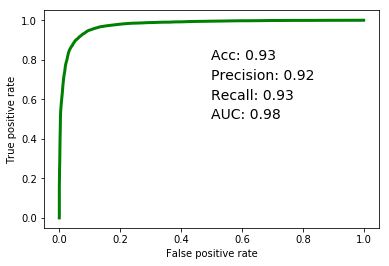

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model_rf.fit(features_w2v, d_train.sentiment)
pred_rf = model_rf.predict_proba(test_features_w2v)
performance(d_test.sentiment, pred_rf)

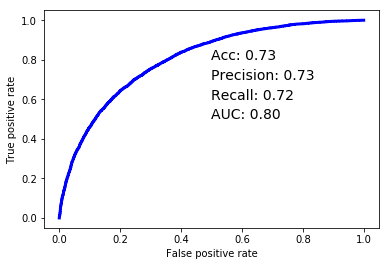

In [21]:
# Navie Bayes

from sklearn.naive_bayes import MultinomialNB
model_NB = MultinomialNB()
model_NB.fit(features_w2v, d_train.sentiment)

pred_NB = model_NB.predict_proba(test_features_w2v)
performance(d_test.sentiment, pred_NB, color="b")

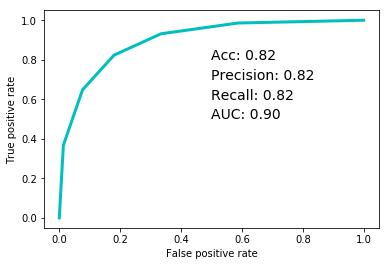

In [22]:
 # K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(features_w2v, d_train.sentiment)

pred_KNN = model_KNN.predict_proba(test_features_w2v)
performance(d_test.sentiment, pred_KNN, color="c")

17500


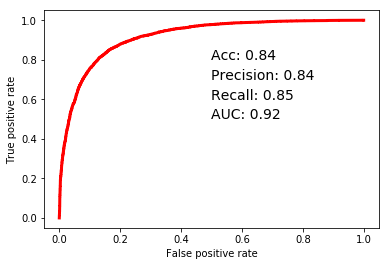

In [23]:
# Neural network models
from sklearn.neural_network import MLPClassifier
model_NNM = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model_NNM.fit(features_w2v, d_train.sentiment)

pred_NNM = model_NNM.predict_proba(test_features_w2v)
performance(d_test.sentiment, pred_NNM, color="r")
print len(d_test.sentiment)

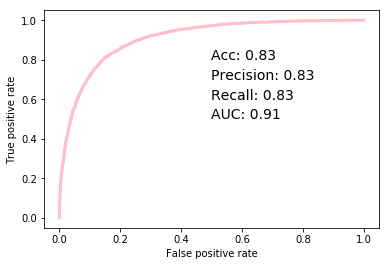

In [24]:
# Support Vector Classification
from sklearn.svm import SVC
model_SVC = SVC(probability=True)
model_SVC.fit(features_w2v, d_train.sentiment)

pred_SVC = model_SVC.predict_proba(test_features_w2v)
performance(d_test.sentiment, pred_SVC, color="pink")


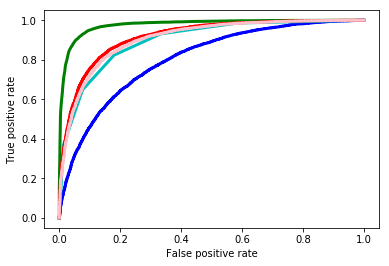

In [25]:
performance(d_test.sentiment, pred_rf,ann = False)
performance(d_test.sentiment, pred_NB, color="b",ann = False)
performance(d_test.sentiment, pred_KNN, color="c",ann = False)
performance(d_test.sentiment, pred_NNM, color="r",ann = False)
performance(d_test.sentiment, pred_SVC, color="pink",ann = False)